In [ ]:
import scipy.io
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import expit
from decimal import Decimal
from keras.datasets import mnist
from sklearn.model_selection import train_test_split

# Artificial Neural Networks

Here we will take a closer look at Neural Netorks, also known as Artificial Neural Networks (ANN) to destinuish them from their biological counterparts and Convolutional Neural Networks (CNN); which will be covered in the next session.

ANNs simulate the brain architecture in that neurons take gets input from synapses and give output to other neurons, thereby forming a directed graph.  

![General neural net graph](./images/general-ann.png)

The topology of this graph can be quite diverse, however we will start with a simple example. We will tag some nodes as special input nodes and some as special output nodes. This is were we will attach the input-output training data to later. The rest of the nodes are simply called "hidden nodes"

![Simple ANN](./images/Artificial_neural_network.svg)

A single neuron takes multiple inputs $x_i$ and give a single output (possible to more than one reciever). The inputs are weighted by some $\theta_i$ (including the bias $\theta_0$) to compute an *activation*

$z = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + ... + \theta_n x_n$

In [96]:
def activation(x, theta):
    answer = theta[0]
    for i in range(len(x)):
        answer += x[i]*theta[i+1]
    return answer

However the activation is typically passed through an activation function. This introduces non-linearity into the formulation which greatly helps in generalizing to complex problems. Different activation functions are available, but the two must videly used are the

## sigmoid function

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(z):
    return 1 / (1+np.exp(-z))

z = np.linspace(-8,8)
plt.plot(z, sigmoid(z))
plt.show()



## rectified linear unit (relu)

In [ ]:
def relu(z):
    return np.maximum(z,0)

z = np.linspace(-8,8)
plt.plot(z, relu(z))
plt.show()

a single neuron with input weights $\theta_i$ can then be programmed as

In [ ]:
def neuron(x,theta):
    return sigmoid(activation(x,theta))

if one choses the sigmoid activation function. The entire network described above can be written as

In [ ]:
# define some input vector
x = [1,3,13]

# compute output for hidden units
a1 = neuron(x, [3,1,1,1]) # output from hidden neuron 1 using weights [3,1,1,1] (first weight is the bias)
a2 = neuron(x, [1,1,2,1]) # output from hidden neuron 2 using weights [1,1,2,1]
a3 = neuron(x, [0,3,2,1]) # output from hidden neuron 2 using weights [0,3,2,1]
a4 = neuron(x, [2,0,0,1]) # output from hidden neuron 2 using weights [2,0,0,1]
a  = [a1,a2,a3,a4]      # wrap all hidden values into a vector

# compute output nodes
y1 = neuron(a, [1,0,0,1,3]) # output neuron 1 using weights [1,0,0,1,3] (first weight is the bias)
y2 = neuron(a, [1,3,9,1,0]) # output neuron 2 using weights [1,3,9,1,0]

We note that every neuron $i$ has a different weight $\theta_j$ and we often denote $\Theta_{ij}$

$$z = \Theta^{(1)} \left[\begin{array}{c} 1 \\ x \end{array}\right]$$

where, in this case we have

$$ \Theta^{(1)} = \left[ \begin{array}{cccc} 3 & 1 & 1 & 1 \\ 1 & 1 & 2 & 1 \\ 0 & 3 & 2 & 1 \\ 2 & 0 & 0 & 1\end{array}\right]$$

Then we compute the activation function (for instance the sigmoid function $\sigma$) and pass this to the next level of the network

$$ a = \sigma(z)$$

Likewise, the output nodes will also have different weights and we write

$$y = \sigma\left(\Theta^{(2)} \left[ \begin{array}{c}1\\a\end{array}\right]\right)$$

$\Theta^{(2)} =\left[\begin{array}{ccccc} 1 & 0 & 0 & 1 & 3 \\ 1 & 3 & 9 & 1 & 0 \end{array}\right]$ in this particular case. This vectorization allow us to create fast implementations of neural networks. $x$ and $y$ are as usual treated as the input and output respectively, while intermediate results are denoted $z$. 

Due to the optimzation possibilities, these *feed forward* networks have become very popular. We can extend this be adding more layers to it. By adding another layer we can start with a vector $x$, then compute a vector $p_1$ using a matrix of weights $\Theta^{(1)}$. Subsequently we compute a vector $p_2$ using a matrix of weights $\Theta^{(2)}$ followed by an output using $\Theta^{(3)}$, giving the following network

![Neural network with 2 hidden layers](./images/Artificial_neural_network_2layers.svg)

We can control the architecture of the network and the activation functions used, but will not manually specify the weights $\Theta$. This is trained using optimization algorithms using [backpropagation](https://en.wikipedia.org/wiki/Backpropagation).

## House price regression using neural networks

For a single hidden layer neural network, then this collapses to logistic regression. We will here implement the network outlined above with a single output neuron

In [95]:
# Read and normalize features
def featureNormalize(X):
    X_norm = X
    mu    = np.zeros((1, X.shape[1]))
    sigma = np.zeros((1, X.shape[1]))
    for i in range(X.shape[1]):
        mu[:,i] = np.mean(X[:,i])
        sigma[:,i] = np.std(X[:,i])
        X_norm[:,i] = (X[:,i] - float(mu[:,i]))/float(sigma[:,i])
    return X_norm, mu, sigma

data = np.loadtxt('./data/housing_data.csv', delimiter=",")
X = data[:,:2]
y = data[:,2]
m = len(y)


We will in the following use the square sum loss function
$$
J(\Theta) = \frac{1}{2m}\sum(y-y_p)^2
$$
with the following gradient
$$
\frac{\partial J}{\partial \Theta_ij} = \frac{1}{m}\sum(y-y_p)^2
$$

In [ ]:
def cost(W,X,y):
    (n,m) = X.shape # n features, m training examples
    
    Theta1 = np.reshape(W[  : 9], (3,3))
    Theta2 = np.reshape(W[ 9:25], (4,4))
    Theta3 = np.reshape(W[25:  ], (5,1))
    z1 = Theta1 * np.vstack(np.ones((1,m)),  X)
    a1 = sigmoid(z1)
    z2 = Theta2 * np.vstack(np.ones((1,m)), a1)
    a2 = sigmoid(z2)
    z3 = Theta3 * np.vstack(np.ones((1,m)), a2)
    yp = sigmoid(z3) # predicted values for one feed-forward iteration
    
    loss = np.sum((yp-y)**2) / 2 / m
    
    # compute the jacobian by partial differentiation
    return (loss, jacobian)

In [ ]:
print('Training Neural Network...')
maxiter = 1000
lambda_reg = 0.1
results = minimize(cost, x0=nn_params, args=(X,y), options={'disp': True, 'maxiter':maxiter}, method="L-BFGS-B", jac=True)

all_weights = results["x"]

Theta1 = np.reshape(all_weights[  : 9], (3,3), order='F')
Theta2 = np.reshape(all_weights[ 9:25], (4,4), order='F')
Theta3 = np.reshape(all_weights[25:  ], (5,1), order='F')


In [ ]:
def displayData(X, example_width=None):
    m,n = X.shape
    plt.figure(figsize=(16,16))
    if X.ndim == 1:
        X = np.reshape(X, (-1,m))
    if not example_width or not 'example_width' in locals():
        example_width = int(round(math.sqrt(X.shape[1])))
    plt.set_cmap("gray")
    example_height = n / example_width
    display_rows = int(math.floor(math.sqrt(m)))
    display_cols = int(math.ceil(m / display_rows))
    pad = 1
    display_array = -np.ones((pad + display_rows * int(example_height + pad),  pad + display_cols * int(example_width + pad)))
    curr_ex = 1
    for j in range(1,display_rows+1):
        for i in range (1,display_cols+1):
            if curr_ex > m:
                break
            max_val = max(abs(X[curr_ex-1, :]))
            rows = pad + (j - 1) * (int(example_height) + pad) + np.array(range(int(example_height)))
            cols = pad + (i - 1) * (int(example_width)  + pad) + np.array(range(int(example_width)))
            display_array[rows[0]:rows[-1]+1 , cols[0]:cols[-1]+1] = np.reshape(X[curr_ex-1, :], (int(example_height), int(example_width)), order="F") / max_val
            curr_ex += 1
            if curr_ex > m:
                break
    h = plt.imshow(display_array.T, vmin=-1, vmax=1)
    plt.axis('off')
    plt.show(block=False)
    return h, display_array

In [ ]:
def predict(Theta1, Theta2, X):
    if X.ndim == 1:
        X = np.reshape(X, (-1,X.shape[0]))
    m = X.shape[0]
    p = np.zeros((m,1))
    X = np.column_stack((np.ones((m,1)), X))
    a2 = sigmoid( np.dot(X,Theta1.T) )
    a2 = np.column_stack((np.ones((a2.shape[0],1)), a2))
    a3 = sigmoid( np.dot(a2,Theta2.T) )
    p = np.argmax(a3, axis=1)
    return p + 1

# Architecture of Deep Neural Network, Cost Function and Regularization
<img src='./images/dnncost.jpg'>

In [ ]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, \
	num_labels, X, y, lambda_reg):
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], \
                     (hidden_layer_size, input_layer_size + 1), order='F')

    Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], \
                     (num_labels, hidden_layer_size + 1), order='F')
    m = len(X)
    J = 0;
    Theta1_grad = np.zeros( Theta1.shape )
    Theta2_grad = np.zeros( Theta2.shape )
    X = np.column_stack((np.ones((m,1)), X)) # = a1
    a2 = sigmoid( np.dot(X,Theta1.T) )
    a2 = np.column_stack((np.ones((a2.shape[0],1)), a2))
    a3 = sigmoid( np.dot(a2,Theta2.T) )

    labels = y
    #One hot encoding
    y = np.zeros((m,num_labels))
    for i in range(m):
    	y[i, labels[i]-1] = 1

    cost = 0
    for i in range(m):
    	cost += np.sum( y[i] * np.log( a3[i] ) + (1 - y[i]) * np.log( 1 - a3[i] ) )
    J = -(1.0/m)*cost
    sumOfTheta1 = np.sum(np.sum(Theta1[:,1:]**2))
    sumOfTheta2 = np.sum(np.sum(Theta2[:,1:]**2))
    J = J + ( (lambda_reg/(2.0*m))*(sumOfTheta1+sumOfTheta2) )
    bigDelta1 = 0
    bigDelta2 = 0
    for t in range(m):
        x = X[t]
        a2 = sigmoid( np.dot(x,Theta1.T))
        a2 = np.concatenate((np.array([1]), a2))
        a3 = sigmoid( np.dot(a2,Theta2.T) )
        delta3 = np.zeros((num_labels))
        for k in range(num_labels):
            y_k = y[t, k]
            delta3[k] = a3[k] - y_k
        delta2 = (np.dot(Theta2[:,1:].T, delta3).T) * sigmoidGradient( np.dot(x, Theta1.T) )
        bigDelta1 += np.outer(delta2, x)
        bigDelta2 += np.outer(delta3, a2)
    Theta1_grad = bigDelta1 / m
    Theta2_grad = bigDelta2 / m
    Theta1_grad_unregularized = np.copy(Theta1_grad)
    Theta2_grad_unregularized = np.copy(Theta2_grad)
    Theta1_grad += (float(lambda_reg)/m)*Theta1
    Theta2_grad += (float(lambda_reg)/m)*Theta2
    Theta1_grad[:,0] = Theta1_grad_unregularized[:,0]
    Theta2_grad[:,0] = Theta2_grad_unregularized[:,0]
    grad = np.concatenate((Theta1_grad.reshape(Theta1_grad.size, order='F'), Theta2_grad.reshape(Theta2_grad.size, order='F')))
    return J, grad

In [ ]:
def randInitializeWeights(L_in, L_out):
    W = np.zeros((L_out, 1 + L_in))
    epsilon_init = 0.12
    W = np.random.rand(L_out, 1 + L_in)*(2*epsilon_init) - epsilon_init
    return W

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
# building the input vector from the 28x28 pixels
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
_,input_layer_size  = X_train.shape  
hidden_layer_size = 25   # 25 hidden units
num_labels = 10

# Resulting 2 Layer Neural Network
<img src='./images/ann.jpg'>

In [ ]:
X=X_train
y=y_train
m,n=X.shape
y=y.flatten()
rand_indices = np.random.permutation(m)
random_images = X[rand_indices[:100],:]
displayData(random_images);

In [ ]:
Theta1=randInitializeWeights(input_layer_size,hidden_layer_size)
Theta2=randInitializeWeights(hidden_layer_size, num_labels)
nn_params = np.concatenate((Theta1.reshape(Theta1.size, order='F'), Theta2.reshape(Theta2.size, order='F')))#

In [ ]:
print('Training Neural Network...')
maxiter = 1000
lambda_reg = 0.1
myargs = (input_layer_size, hidden_layer_size, num_labels, X, y, lambda_reg)
results = minimize(nnCostFunction, x0=nn_params, args=myargs, options={'disp': True, 'maxiter':maxiter}, method="L-BFGS-B", jac=True)

nn_params = results["x"]

Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)], \
                 (hidden_layer_size, input_layer_size + 1), order='F')

Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], \
                 (num_labels, hidden_layer_size + 1), order='F')

In [ ]:
print('\nVisualizing Neural Network layer 1 \n')
displayData(Theta1[:, 1:]);

In [ ]:
print('\nVisualizing Neural Network layer 1 \n')
displayData(Theta2[:, 1:]);

In [ ]:
pred = predict(Theta1, Theta2, X)

In [ ]:
# uncomment code below to see the predictions that don't match
# fmt = '{}   {}'
# print(fmt.format('y', 'pred'))
# for y_elem, pred_elem in zip(y, pred):
#     if y_elem != pred_elem:
#         print(fmt.format(y_elem%10, pred_elem%10))

print('Training Set Accuracy: {:f}'.format( ( np.mean(pred == y)*100 ) ) )

#for i in range(m):
#    print('Displaying Example Image')
#    displayData(X[rp[i], :].reshape(1,-1))
#    pred = predict(Theta1, Theta2, X[rp[i], :])
#    print('Neural Network Prediction: {:d} (digit {:d})'.format(pred[0], (pred%10)[0]))
#    input('Program paused. Press enter to continue.\n')

# Solve using Keras with Tensorflow backend

We will now create a neural network to be for recoqnizing hand-written digits using the Keras library. First we will download and inspect the dataset.

In [11]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


    This is a set of 60,000 images (28x28 pixels grayscale) of hand-written digits. We can display the first few images

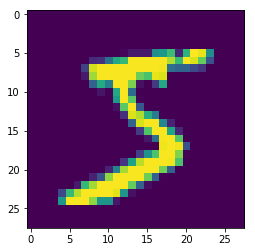

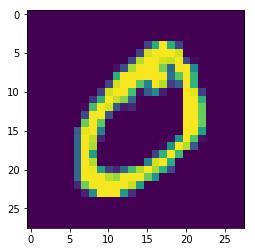

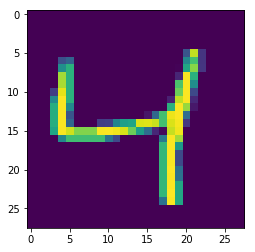

In [27]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0])
plt.show()
plt.imshow(X_train[1])
plt.show()
plt.imshow(X_train[2])
plt.show()

In [25]:
# by inspecting the training labels, we see what these images are ment to show
print(y_train[0:3])

[5 0 4]


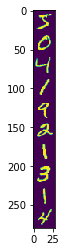

[5 0 4 1 9 2 1 3 1 4]


In [38]:
# we can plot the first 10 digits in a single plot by reshaping the image data
plt.imshow(X_train[:10,:,:].reshape((28*10,28)))
plt.show()
print(y_train[:10])

We will now convert the input data to the right representation


In [46]:
from sklearn.preprocessing import LabelBinarizer

# all inputs are defined as vectors, i.e. we collapse a 28x28 image to a 784 feature vector
X  = X_train.reshape(60000,784)
Xt = X_test.reshape(10000,784)

# all outputs are defined as categorical values. We do a one-hot encoding of these
categorical_transform = LabelBinarizer().fit(np.arange(10)) # labels are in the range [0,10]
y  = categorical_transform.transform(y_train)
yt = categorical_transform.transform(y_test)

print(y[:10,:])
print(y_train[:10])

[[0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]
[5 0 4 1 9 2 1 3 1 4]


We will now create a Neural Network model in Keras using the Sequential model

In [70]:
from keras.models import Sequential
from keras.layers import Dense

# create a model of sequential layers 
model = Sequential()

# add the first layer, this *requires* you to specify the input dimension (our 28*28=784 px images)
model.add(Dense(input_dim=784, units = 100, activation='sigmoid'))

# add the second layer. All layers require you to specify the number of neurons (units)
model.add(Dense(               units =  50, activation='sigmoid'))

# the third and final output layer. We here use the 'softmax' activation function since we want to classify
# the numbers [0-9] with a percentage prediction
model.add(Dense(               units =  10, activation='softmax'))

# finish the model and compile it so it is ready for training
model.compile(optimizer= 'adam',                     
              loss     = 'categorical_crossentropy',
              metrics  = ['accuracy'])

We now train the model on the training set.

In [71]:
model.fit(X, y,
         epochs=10,
         batch_size=100,
         validation_data=(Xt,yt))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 38us/step - loss: 0.7632 - acc: 0.8309 - val_loss: 0.3814 - val_acc: 0.9008
Epoch 2/10
60000/60000 [==============================] - 2s 35us/step - loss: 0.3507 - acc: 0.9026 - val_loss: 0.3212 - val_acc: 0.9074
Epoch 3/10
60000/60000 [==============================] - 2s 41us/step - loss: 0.3204 - acc: 0.9059 - val_loss: 0.2864 - val_acc: 0.9151
Epoch 4/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.2943 - acc: 0.9142 - val_loss: 0.2869 - val_acc: 0.9123
Epoch 5/10
60000/60000 [==============================] - 2s 32us/step - loss: 0.2775 - acc: 0.9174 - val_loss: 0.2735 - val_acc: 0.9166
Epoch 6/10
60000/60000 [==============================] - 2s 38us/step - loss: 0.2700 - acc: 0.9185 - val_loss: 0.2599 - val_acc: 0.9229
Epoch 7/10
60000/60000 [==============================] - 2s 34us/step - loss: 0.2632 - acc: 0.9203 - val_loss: 0.2566 - val_acc

We now test our model on one of the test images. Remember that the test images are *not* used for updating the weights, so this is considered an unseen example image by the model

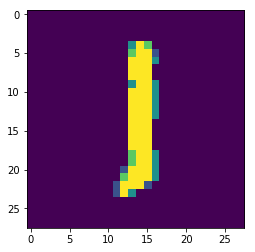

This is actually a 1

[[  6.81431970e-07   9.88680124e-01   2.59935798e-04   9.39901825e-03
    3.33482285e-06   5.68995427e-04   2.63311904e-05   2.73413723e-04
    6.65243657e-04   1.22930855e-04]]

98.86801242828369 % chance of this being a 1


In [66]:
i = 14 # choose one test image index

# show one of the test images
plt.imshow(X_test[i,:,:])
plt.show()
print('This is actually a', y_test[i]) # this is what it is *supposed* to be
print()

# do a prediction using our model
prediction = model.predict(X_test[i,:,:].reshape(1,28*28)) # remember to roll the image data into a vector

# the prediction is a vector of 10 (output nodes) with % probability of that being the shown digit (softmax function)
print(prediction)
print()
print('{} % chance of this being a {}'.format(prediction[0,y_test[i]]*100, y_test[i]))

Usually the weights are quite opaque, meaning that they are hard to interpret. In many applications this is not a problem; as the saying goes "all models are wrong, some are usefull". However if one wants a better understanding of what the model does, one can look at the equations. The predictions appear as a sequence of matrix-vector multiplications followed by application of the activation function. Ignoring the bias for now, they take the form:

$$ z_1 = \sigma\left( \Theta^{(1)} x  \right) \\
   z_2 = \sigma\left( \Theta^{(2)} z_1\right) \\
   y   = \sigma\left( \Theta^{(3)} z_2\right) $$

for our 3-layer neural network. Seing as the activation function, all take low values and map thems them to other low values and likewise for high values (monotonly growing function), it is not unreasonable to assume that a good approximation of neural importance comes from omitting the activation function to get

$$ y \approx \Theta^{(3)} \Theta^{(2)} \Theta^{(1)} x $$

If we call $\Theta = \Theta^{(3)} \Theta^{(2)} \Theta^{(1)}$, then this matrix will map from 784 image pixels to 10 digit predictions. We may get this matrix by

In [92]:
theta1 = model.layers[0].get_weights()[0] # returns a tuple of weights and the bias, we only care about weights now
theta2 = model.layers[1].get_weights()[0]
theta3 = model.layers[2].get_weights()[0]

print(theta1.shape)
print(theta2.shape)
print(theta3.shape)
# keras stores the weights as the transpose of the above, so we correct these
theta1 = theta1.T
theta2 = theta2.T
theta3 = theta3.T
theta = theta3.dot(theta2).dot(theta1)
print(theta.shape)

(784, 100)
(100, 50)
(50, 10)
(10, 784)


Seing as the inputs are considered image pixels, we may now draw reinpret the effect of $\Theta$ as image pixels. We reshape from 784 to (28,28) and draw the 10 images resulting from this

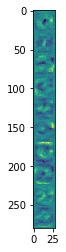

In [94]:
image_intepretation = theta.reshape(28,28,10)
plt.imshow(image_intepretation.reshape(28*10,28)) # reshape to 10 images down
plt.show()

Dark areas signify negative fedback while bright positive. Thus for the upper image, one can see a trace of a bright zero meaning that if pixel values in this region appears, this will count positively for this being the number '0'. The same image has a dark area in its center meaning that pixels in this region will count negative for this being a '0'.

# A stand-alone training model
The above model can be compactly written as

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense

# create preprocessor
categorical_transform = LabelBinarizer().fit(np.arange(10))

# load and transform data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X  = X_train.reshape(60000,784)
Xt = X_test.reshape(10000,784)
y  = categorical_transform.transform(y_train)
yt = categorical_transform.transform(y_test)

# create model
model = Sequential()
model.add(Dense(input_dim=784, units = 100, activation='sigmoid'))
model.add(Dense(               units =  50, activation='sigmoid'))
model.add(Dense(               units =  10, activation='softmax'))

# compile model
model.compile(optimizer= 'adam',                     
              loss     = 'categorical_crossentropy',
              metrics  = ['accuracy'])

# train model
model.fit(X, y,
         epochs=10,
         batch_size=100,
         validation_data=(Xt,yt))
